In [1]:
import torch
import torch.nn as nn
from transformers import AutoModel


class FineTuneClassifier(nn.Module):
    def __init__(self, base_model_path: str, num_labels: int) -> None:
        super(FineTuneClassifier, self).__init__()
        self.base_model = AutoModel.from_pretrained(base_model_path)

        for param in self.base_model.parameters():
            param.requires_grad = False

        self.classifier = nn.Linear(self.base_model.config.hidden_size * 2, num_labels)

    @classmethod
    def from_classifier_head(
        cls, base_model_path: str, path: str, num_labels: int
    ) -> nn.Module:
        model = cls(base_model_path, num_labels)
        model.classifier.load_state_dict(torch.load(path))
        return model

    def forward(
        self, input_ids: torch.tensor, attention_mask: torch.tensor
    ) -> torch.tensor:
        outputs = self.base_model(input_ids=input_ids, attention_mask=attention_mask)
        B, T, C = outputs.logits.shape

        all_tokens_hidden = outputs.logits  # (B, T, C)
        last_token_hidden = outputs.logits[:, -1, :]  # (B, C)
        last_token_hidden = last_token_hidden.unsqueeze(1).expand(B, T, C)

        combined_representation = torch.cat(
            (all_tokens_hidden, last_token_hidden), dim=-1
        )
        logits = self.classifier(combined_representation)
        return logits


class BaselineClassifier(nn.Module):
    def __init__(
        self,
        d_model: int,
        num_layers: int,
        nhead: int,
        max_seq_length: int,
        vocab_size: int,
        pad_token_id: int,
        num_labels: int,
    ) -> None:
        super(BaselineClassifier, self).__init__()
        self.pad_token_id = pad_token_id
        self.token_embedding = nn.Embedding(
            vocab_size, d_model, padding_idx=pad_token_id
        )
        self.pos_embedding = nn.Embedding(max_seq_length, d_model)
        decoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(decoder_layer, num_layers=num_layers)
        self.classifier = nn.Linear(d_model * 2, num_labels)

    def forward(self, token_ids: torch.tensor) -> torch.tensor:
        batch_size, seq_len = token_ids.shape

        token_emb = self.token_embedding(token_ids)
        pos_ids = torch.arange(seq_len, device=token_ids.device).unsqueeze(0)
        pos_emb = self.pos_embedding(pos_ids)
        embeddings = token_emb + pos_emb

        causal_mask = torch.triu(
            torch.ones(seq_len, seq_len, device=token_ids.device, dtype=torch.bool),
            diagonal=1,
        )

        pad_mask = token_ids.eq(self.pad_token_id)  # shape: (batch_size, seq_len)

        output = self.transformer(
            embeddings, mask=causal_mask, src_key_padding_mask=pad_mask
        )

        B, T, C = output.shape
        all_tokens_hidden = output  # (B, T, C)
        last_token_hidden = output[:, -1, :]  # (B, C)
        last_token_hidden = last_token_hidden.unsqueeze(1).expand(B, T, C)

        combined_representation = torch.cat(
            (all_tokens_hidden, last_token_hidden), dim=-1
        )
        logits = self.classifier(combined_representation)
        return logits


In [2]:
from typing import Dict
BASELINE_MODELS: Dict[str, Dict[str, int]] = {
    "mini": {
        "d_model": 64,
        "num_layers": 4,
        "num_heads": 4,
        "max_len": 16_384,
    },
    "small": {
        "d_model": 510,
        "num_layers": 8,
        "num_heads": 6,
        "max_len": 16_384,
    },
    "medium": {
        "d_model": 1344,
        "num_layers": 24,
        "num_heads": 16,
        "max_len": 16_384,
    },
    "large": {
        "d_model": 1824,
        "num_layers": 36,
        "num_heads": 24,
        "max_len": 16_384,
    },
}

In [5]:
tmp()

Model: mini, Total Parameters: 10.49M, % emb parameters: 0.7928761601769944
Active params: 2.17M, emb params: 8.32M
Used VRAM: 40.30 MB
Model: small, Total Parameters: 99.75M, % emb parameters: 0.6646892012547166
Active params: 33.45M, emb params: 66.30M
Used VRAM: 380.63 MB
Model: medium, Total Parameters: 502.61M, % emb parameters: 0.34762279350401076
Active params: 327.89M, emb params: 174.72M
Used VRAM: 1918.55 MB
Model: large, Total Parameters: 1015.72M, % emb parameters: 0.23345000116597012
Active params: 778.60M, emb params: 237.12M
Used VRAM: 3874.75 MB


In [4]:
def tmp():
    for name, config in BASELINE_MODELS.items():
        d_model = config["d_model"]
        num_layers = config["num_layers"]
        nhead = config["num_heads"]
        max_seq_length = config["max_len"]
        vocab_size = 130_000
        pad_token_id = 0
        num_labels = 2

        model = BaselineClassifier(
            d_model,
            num_layers,
            nhead,
            max_seq_length,
            vocab_size,
            pad_token_id,
            num_labels,
        )
        total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        emb_params = vocab_size * d_model

        model.cuda()
        used_memory = torch.cuda.memory_allocated(device=torch.device("cuda:0"))
        print(f"Model: {name}, Total Parameters: {total_params / 1e6:.2f}M, % emb parameters: {emb_params/total_params}")
        print(f"Active params: {(total_params - emb_params) / 1e6:.2f}M, emb params: {emb_params / 1e6:.2f}M")
        print(f"Used VRAM: {used_memory / (1024 ** 2):.2f} MB")

In [64]:
import pandas as pd

In [66]:
df = pd.read_csv("../data/stats/data_stats_master.csv")
df.head()

,data,model,num_samples,num_sentences,num_words,num_chars,num_tokens
0,nyt-comments,human,4223213,18713269,342590681,1418281599,367129360
1,blogs,human,576731,8328325,150710195,557327652,164361476
2,raid,human,138244,1808791,46559309,215280947,95664352
3,natural-questions,human,231628,544545,12325780,52665339,14758108
4,writingprompts,human,303140,13802625,196423260,721935184,209317891


In [67]:
df[df["model"] == "human"][["data", "num_samples", "num_sentences", "num_words", "num_tokens"]].sort_values("data")

,data,num_samples,num_sentences,num_words,num_tokens
1,blogs,576731,8328325,150710195,164361476
5,essays,2638,123010,1883626,1910971
3,natural-questions,231628,544545,12325780,14758108
6,nyt-articles,15813,21318,397111,421258
0,nyt-comments,4223213,18713269,342590681,367129360
2,raid,138244,1808791,46559309,95664352
8,reddit,655484,1817601,30286813,32563547
7,tweets,389916,735759,7479175,8375173
4,writingprompts,303140,13802625,196423260,209317891
9,xsum,226394,4298208,97475080,105943034


In [76]:
df[df["model"] == "human"][["data", "num_samples", "num_sentences", "num_words", "num_tokens"]].sum()

data             nyt-commentsblogsraidnatural-questionswritingp...
num_samples                                                6763201
num_sentences                                             50193451
num_words                                                886131030
num_tokens                                              1000445170
dtype: object

In [68]:
df.groupby("data").sum().reset_index()[["data", "num_samples", "num_sentences", "num_words", "num_tokens"]].sort_values("data")

,data,num_samples,num_sentences,num_words,num_tokens
0,blogs,1182270,21203468,381085553,407027203
1,essays,58036,2765379,40240176,39439570
2,natural-questions,474227,2279452,46437493,58791916
3,nyt-articles,347885,2165238,60102771,63994699
4,nyt-comments,8657565,36261238,705529033,746827854
5,raid,864020,10784314,264179188,332672877
6,reddit,3408276,14035572,296477342,340254517
7,tweets,3665193,8117363,97242239,117976085
8,writingprompts,621437,23319770,379307258,399447670
9,xsum,939528,12847512,339556027,360436581


In [77]:
df.groupby("data").sum().reset_index()[["data", "num_samples", "num_sentences", "num_words", "num_tokens"]].sort_values("data").sum()

data             blogsessaysnatural-questionsnyt-articlesnyt-co...
num_samples                                               20218437
num_sentences                                            133779306
num_words                                               2610157080
num_tokens                                              2866868972
dtype: object

In [78]:
df.groupby("model").sum().reset_index()[["model", "num_samples", "num_sentences", "num_words", "num_tokens"]]

,model,num_samples,num_sentences,num_words,num_tokens
0,Falcon3-3B-Instruct,640766,3161253,67838176,72520075
1,Falcon3-7B-Instruct,640767,3176223,67428463,71932999
2,Llama-3.1-8B-Instruct,640541,3050731,70507468,73979179
3,Llama-3.2-3B-Instruct,640759,3045728,71913423,75775399
4,Meta-Llama-3.1-70B-Instruct-AWQ-INT4,640750,2994366,64801390,67950245
5,Meta-Llama-3.3-70B-Instruct-AWQ-INT4,640766,2861116,69234095,72319091
6,Ministral-8B-Instruct-2410,640767,5700407,94563415,98615451
7,Mistral-Nemo-Instruct-2407,640765,4684474,86356229,91252590
8,Phi-3-medium-128k-instruct,640193,4937858,100324679,107425744
9,Phi-3-mini-128k-instruct,640760,5390937,87882920,92987021


In [80]:
df.groupby("model").sum().reset_index()[["model", "num_samples", "num_sentences", "num_words", "num_tokens"]].sum()

model            Falcon3-3B-InstructFalcon3-7B-InstructLlama-3....
num_samples                                               20218437
num_sentences                                            133779306
num_words                                               2610157080
num_tokens                                              2866868972
dtype: object

In [81]:
df["is_human"] = df["model"].apply(lambda x: 1 if x == "human" else 0)

In [82]:
df.groupby("is_human").sum()[["num_samples", "num_sentences", "num_words", "num_tokens"]].reset_index()

,is_human,num_samples,num_sentences,num_words,num_tokens
0,0,13455236,83585855,1724026050,1866423802
1,1,6763201,50193451,886131030,1000445170


In [ ]:
import torch
import torch.nn as nn
from transformers import AutoModel


class FineTuneClassifier(nn.Module):
    def __init__(self, base_model_path: str, num_labels: int) -> None:
        super(FineTuneClassifier, self).__init__()
        self.base_model = AutoModel.from_pretrained(base_model_path)

        for param in self.base_model.parameters():
            param.requires_grad = False

        self.classifier = nn.Linear(self.base_model.config.hidden_size * 2, num_labels)

    @classmethod
    def from_classifier_head(
        cls, base_model_path: str, path: str, num_labels: int
    ) -> nn.Module:
        model = cls(base_model_path, num_labels)
        model.classifier.load_state_dict(torch.load(path))
        return model

    def forward(
        self, input_ids: torch.tensor, attention_mask: torch.tensor
    ) -> torch.tensor:
        outputs = self.base_model(input_ids=input_ids, attention_mask=attention_mask)
        B, T, C = outputs.logits.shape

        all_tokens_hidden = outputs.logits  # (B, T, C)
        last_token_hidden = outputs.logits[:, -1, :]  # (B, C)
        last_token_hidden = last_token_hidden.unsqueeze(1).expand(B, T, C)

        combined_representation = torch.cat(
            (all_tokens_hidden, last_token_hidden), dim=-1
        )
        logits = self.classifier(combined_representation)
        return logits


class BaselineClassifier(nn.Module):
    def __init__(
        self,
        d_model: int,
        num_layers: int,
        nhead: int,
        max_seq_length: int,
        vocab_size: int,
        pad_token_id: int,
        num_labels: int,
    ) -> None:
        super(BaselineClassifier, self).__init__()
        self.pad_token_id = pad_token_id
        self.token_embedding = nn.Embedding(
            vocab_size, d_model, padding_idx=pad_token_id
        )
        self.pos_embedding = nn.Embedding(max_seq_length, d_model)
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=d_model, nhead=nhead, batch_first=True
        )
        self.transformer = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)
        self.classifier = nn.Linear(d_model * 2, num_labels)

    def forward(self, token_ids: torch.tensor) -> torch.tensor:

        token_emb = self.token_embedding(token_ids)

        output = self.transformer(
            token_emb, 
        )

        B, T, C = output.shape
        all_tokens_hidden = output  # (B, T, C)
        last_token_hidden = output[:, -1, :]  # (B, C)
        last_token_hidden = last_token_hidden.unsqueeze(1).expand(B, T, C)

        combined_representation = torch.cat(
            (all_tokens_hidden, last_token_hidden), dim=-1
        )
        logits = self.classifier(combined_representation)
        return logits


In [58]:
import torch
from torchviz import make_dot

# Assuming your BaselineClassifier is defined
model = BaselineClassifier(
    d_model=128,
    num_layers=2,
    nhead=4,
    max_seq_length=100,
    vocab_size=30522,
    pad_token_id=0,
    num_labels=10
)

dummy_input = torch.randint(0, 30522, (2, 100))  # (batch_size, seq_len)
output = model(dummy_input)

# Create the computation graph
dot = make_dot(output, params=dict(model.named_parameters()))
dot.render("baseline_classifier", format="png")  # Saves a .png file


'baseline_classifier.png'

In [52]:
from torchview import draw_graph

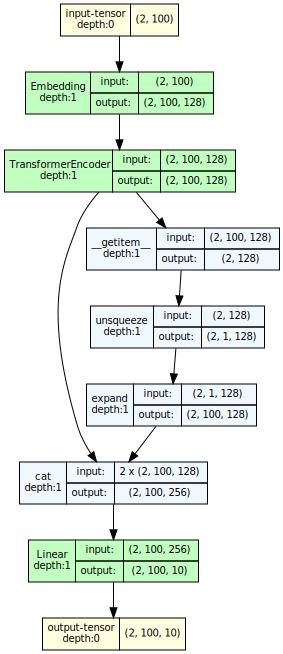

In [53]:
model_graph = draw_graph(model, input_data=dummy_input, depth=1)

model_graph.visual_graph

In [6]:
import tiktoken

In [7]:
tokenizer = tiktoken.get_encoding("o200k_base")

In [9]:
tokenizer.n_vocab

200019